#  Banknote classification with fcNN

This notebook is based on nb_ch02_02 from https://tensorchiefs.github.io/dl_book/ 

Thanks to Michael Prummer and Lars Bosshard who adpated large parts of the code from Python to R as part of a DL coaching with Beate.

__Goal__: In this notebook you will do your first classification. You will see that fully connected networks without a hidden layer can only learn linar decision boundaries, while fully connected networks with hidden layers are able to learn non-linear decision boundaries.

__Usage__: The idea of the notebook is that you try to understand the provided code. Run it, check the output, and play with it by slightly changing the code. There are some questions the answer along the code

__Dataset__: You work with a banknote data set and classification task. We have 5 features that were extracted from wavelet transformed images of banknotes:

1. variance (continuous feature)

2. skewness (continuous feature)

3. curtosis (continuous feature)

4. entropy (continuous feature)

5. class (binary indicating if the banknote is real or fake)

Don't bother too much how these features exactely came from.
For this analysis we only use 2 features.


x1: skewness of wavelet transformed image

x2: entropy of wavelet transformed image

__The goal is to classify each banknote to either "real" (Y=0) or "fake" (Y=1), or in a probabilistic model to predict the probability for "real" or "fake".__

__Content:__

* visualize the data in a simple scatter plot and color the points by the class label
* use the Keras library to build a fcNN without hidden layers (logistic regression).
* visualize the learned decision boundary in a 2D plot
* use the Keras library to build a fcNN with a single hidden layer. 
* visualize the learned decision boundary in a 2D plot
* compare the performace and the decision boundaries of the two models
* stack more hidden layers to the model and playaround with the epochs


## Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
#Installing TF and Keras takes approx 2 minutes
ptm <- proc.time()
install.packages("tensorflow")
install.packages("keras")
install.packages("RCurl")
install.packages("kableExtra")
proc.time() - ptm
#devtools::install_github("rstudio/keras") works ok but no tfp
library(keras)
library(tensorflow)
tf$version$VERSION #2.3.0

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   user  system elapsed 
 41.296   4.861  46.934 

[1] "2.12.0"

## Imports and loading the data

In the next cell, we load all the required libraries and functions. 
We also download the data with the 5 featues from the provided url.

In [2]:
library(keras)
library(RCurl)
library(ggplot2)
#library(kableExtra)
myurl = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/"
fname = "data_banknote_authentication.txt"
myurl = paste0(myurl, fname)
if(url.exists(myurl)) {
  dataset = read.table(myurl, sep=",")
}
dim(dataset)

[1] 1372    5

The object _dataset_ has 1372 rows and 5 columns.

Let's extract the two featues _x1: skewness of wavelet transformed image_ and _x2: entropy of wavelet transformed image_. We print the shape and see that we for X we have 1372 oberservations with two featues and for Y there are 1372 binary labels.

In [3]:
X = dataset[, c(2,4)]
X = as.matrix(X)
Y = dataset[, 5]

str(X)
str(Y)

 num [1:1372, 1:2] 8.67 8.17 -2.64 9.52 -4.46 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "V2" "V4"
 int [1:1372] 0 0 0 0 0 0 0 0 0 0 ...


### Visualization of the data set
Since the banknotes are described by only 2 features, we can easily visualize the positions of real and fake banknotes in the 2D feature space. You can see that the boundary between the two classes is not separable by a straight line. A curved boundary line will do better. But even then we cannot expect a perfect seperation.

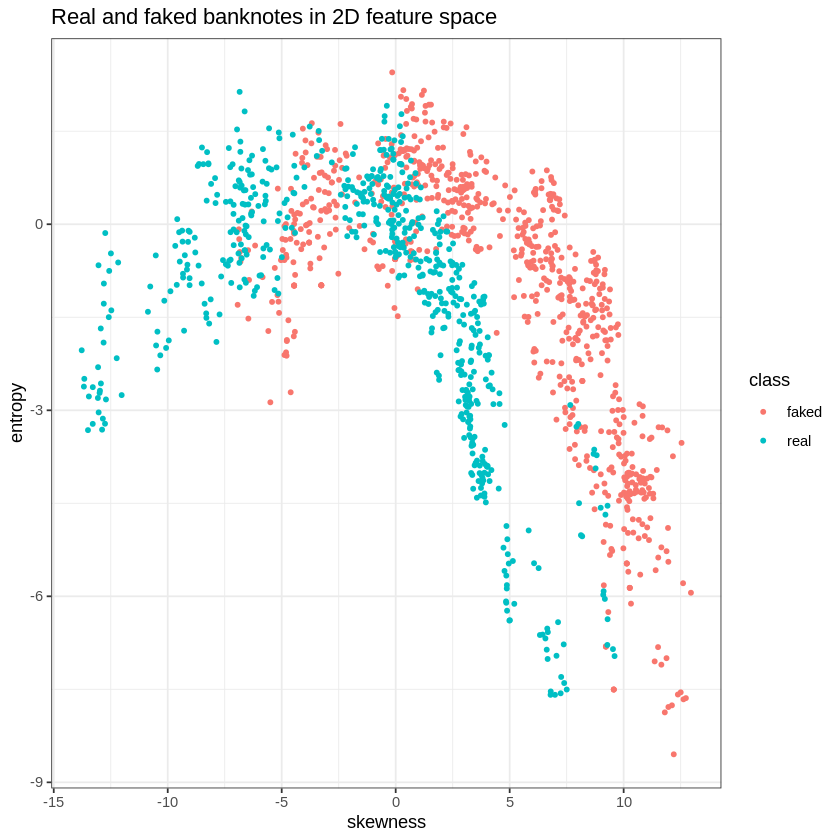

In [4]:
d.plot = data.frame(skewness = dataset[, 2], 
                    entropy = dataset[, 4], 
                    class = c("faked", "real")[dataset[, 5]+1])
ggplot(d.plot, aes(x=skewness, y=entropy, color=class)) + 
  geom_point(size=1) + 
  ggtitle("Real and faked banknotes in 2D feature space") + theme_bw()

## fcNN with only one neuron

Let’s try to use a single neuron with a sigmoid activation function (also known as logistic regression) as model to seperate the banknotes.


### Solution with Keras

We now build the network using the keras API. First, we define the network, via:

#### Definition of the model

We use the sequential API from keras to build the model without hidden layers. 

**Questions (try to answer them before looking at the answers below)**: 

* Why is the number of parameters in this NN 3?
* How many parameters would you expect if we would have 5 features?
* How would the code look if we take all 5 features? 
* How will the decision boundary between the two classes look like?

#### Compiling the network

In [32]:
# Definition of the network
model = keras_model_sequential()       # starts the definition of the network
model %>%
  layer_dense(units = 1,               # adds a new layer to the network with a single neuron
              input_shape = c(2),      # The input is a tensor of size (batch_size, 2), since we don’t specify the Batch Size now
              activation = "sigmoid")  # chooses the activation function ‘sigmoid’
summary(model)


Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_5 (Dense)                    (None, 1)                       3           
Total params: 3
Trainable params: 3
Non-trainable params: 0
________________________________________________________________________________


In [33]:
#sgd = optimizer_sgd(lr=0.15)           # Defining the stochastic gradient descent optimizer

# compile model                        # compile model, which ends the definition of the model 
compile(model,
        loss = 'binary_crossentropy',
         optimizer = optimizer_adam(), # stochastic gradients with extras
         metrics = c('accuracy')
        )

#### Fit Network

In [34]:
# Training of the network
history = fit(model, X, Y,              # training of the model using the training data stored in X and Y
          epochs=400,                   # for 400 epochs
          batch_size=128,               # fix the batch size to 128 examples
          verbose=0)

Let's look at the so called learning curve, we plot the accuracy and the loss vs the epochs. You can see that after 100 epochs, we predict around 70% of our data correct and have a loss aorund 0.51 (this values can vary from run to run).

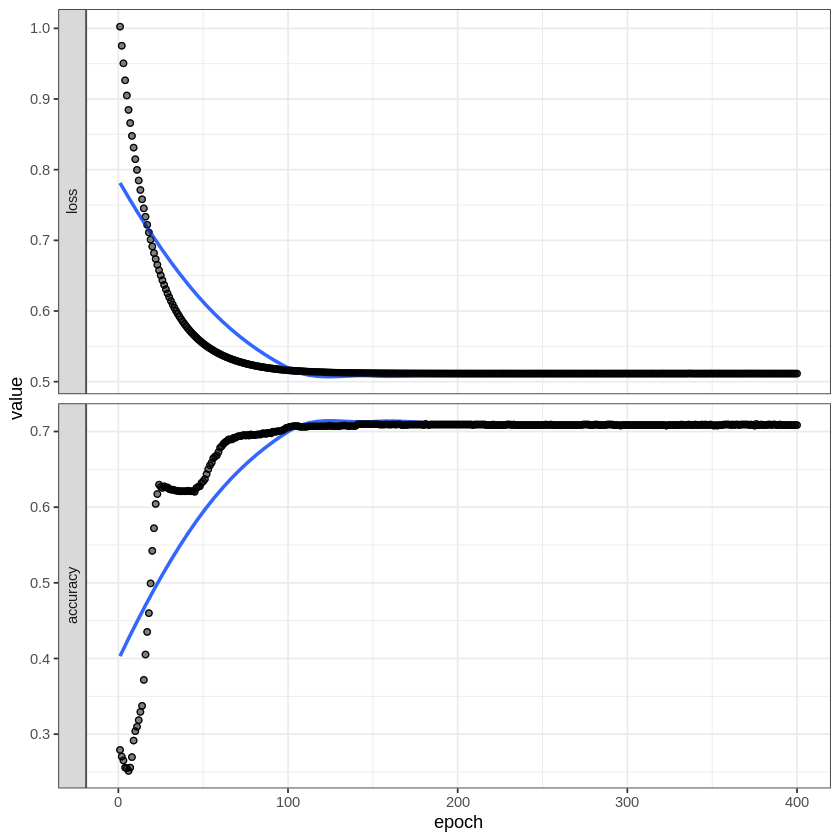

In [35]:
plot(history) + geom_point(alpha = 0.5) + theme_bw()

We can extract the weights of the model. They should be similat to the approach in TensorFlow.

In [36]:
model$get_weights()

-0.3287699
-0.5266677


#### Plotting the learned decision boundary

Let's visualize which decision boundary was learned by the fcNN with only one output neuron (and no hidden layer). As you can see the decision boundary is a straight line. This is not a coincidence but a general property of a single artificial neuron with a sigmoid as activation function and no hidden layer, also known as logistic regression.

In [37]:
# There is a bug in farver_2.0.1 which is currently shiped in the default colab notebooks
# We need to install the latest version of the package so that plotModel works
install.packages('farver')
library(farver)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



##### writing a plot function to visualize the decision boundaries

The following function visualizes the predicted probabilities over a grid of the feature space and hence make the decision boundary visible.


In [12]:
# define a grid for the 2D feature space
# predict at each grid point the probability for class 1
plotModel = function(X, Y, model, title){
  test.grid = expand.grid(seq(-15, 15, length.out = 100),seq(-9, 3, length.out = 100))
  test.grid = as.matrix(test.grid)  
  y.pred = predict(model, test.grid)
  if(length(dim(y.pred))==2 & dim(y.pred)[2]==2) y.pred = y.pred[, 2]
  y.plot = data.frame(skewness=test.grid[,1], entropy=test.grid[,2], class.pred=y.pred)
  ggplot() +
    geom_raster(data=y.plot, aes(x=skewness, y=entropy, fill=class.pred)) + 
    scale_fill_distiller(name="P(real)", palette = "RdBu", limits=c(0,1)) +
    geom_point(data=d.plot, aes(x=skewness, y=entropy, color=class), size=1)  
}


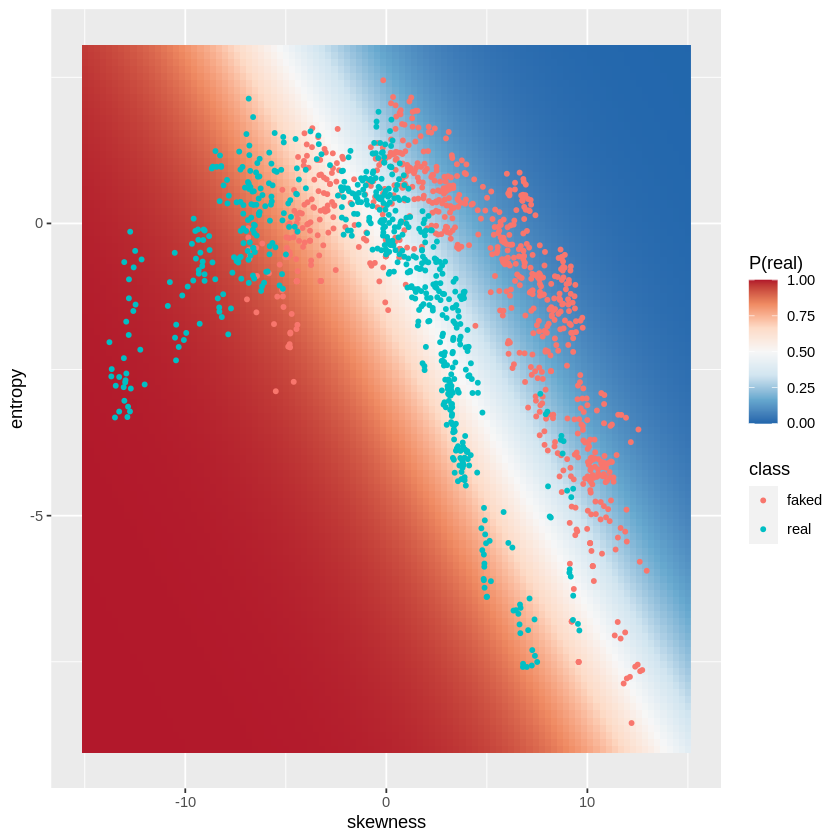

In [40]:
plotModel(X, Y, model, "fcnn separation without hidden layer")

**Anserwers to the questions above**: 

* we have 2 input nodes which are connected to a single output nodes and the weights of these connections give two parameters, in addition we have one bias that gives an additional parameter, resulting all over in 2+1=3 parameters.

* in case of 5 features we would have 5+1=6 parameters.

* the code for 5 features is given in the cell below.

* The decision boundary between the two classes is linear, if the NN has no hidden layers.

In [41]:
# Definition of the network
model = keras_model_sequential()       # starts the definition of the network
model %>%
  layer_dense(units = 1,               # adds a new layer to the network with a single neuron
              input_shape = c(5),      # The input is a tensor of size (batch_size, 2), since we don’t specify the Batch Size now
              activation = "sigmoid")  # chooses the activation function ‘sigmoid’
summary(model)

Model: "sequential_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_6 (Dense)                    (None, 1)                       6           
Total params: 6
Trainable params: 6
Non-trainable params: 0
________________________________________________________________________________


## fcNN with one hidden layer

Looking at the visualization of the data tells us that the boundary between the two classes is not very well captured by a line. Therefore a single neuron is not appropriate to model the probability for a fake banknote based on its two features. To get a more flexible model, we introduce an additional layer between input layer and output layer. This is called hidden layer. Here we use a hidden layer with 8 neurons. We also change the ouputnodes form 1 to 2, to get two ouputs for the probability of real and fake banknote. Because we now have 2 outputs, we use the softmax activation function in the output layer. The softmax activation ensures that the output can be interpreted as a probability (see chapter 2 in our book for details)

### Definition of the network

In [7]:
# Definition of the network
#model = keras_model_sequential()
#model = layer_dense(model, units=8, activation='sigmoid', input_shape=c(2))
#model = layer_dense(model, units=2, activation='softmax')

model = keras_model_sequential()
model = layer_dense(model, units=8, activation='sigmoid', input_shape=c(2))
model = layer_dense(model, units=1, activation='sigmoid')

# compile model                        # compile model, which ends the definition of the model 
compile(model,
        loss = 'binary_crossentropy',
        optimizer = optimizer_adam(),
        metrics = c('accuracy')
        )
summary(model)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_4 (Dense)                    (None, 8)                       24          
 dense_5 (Dense)                    (None, 1)                       9           
Total params: 33
Trainable params: 33
Non-trainable params: 0
________________________________________________________________________________


### Fit Network

In the next cell, train the network. In other words, we tune the parameters (weight, biases) that were initialized randomly with stochastic gradient descent to minimize our loss function (the categorical crossentropy). We set the batchsize to 128 per updatestep and train for 400 epochs.

In [8]:
history = fit(model, X, Y, epochs=400, batch_size=128)

Let's look again at the leraning curve, we plot the accuracy and the loss vs the epochs. You can see that after 100 epochs, we predict around 86% of our data correct and have a loss aorund 0.29 (this values can vary from run to run). This is already alot better than the model without a hidden layer.

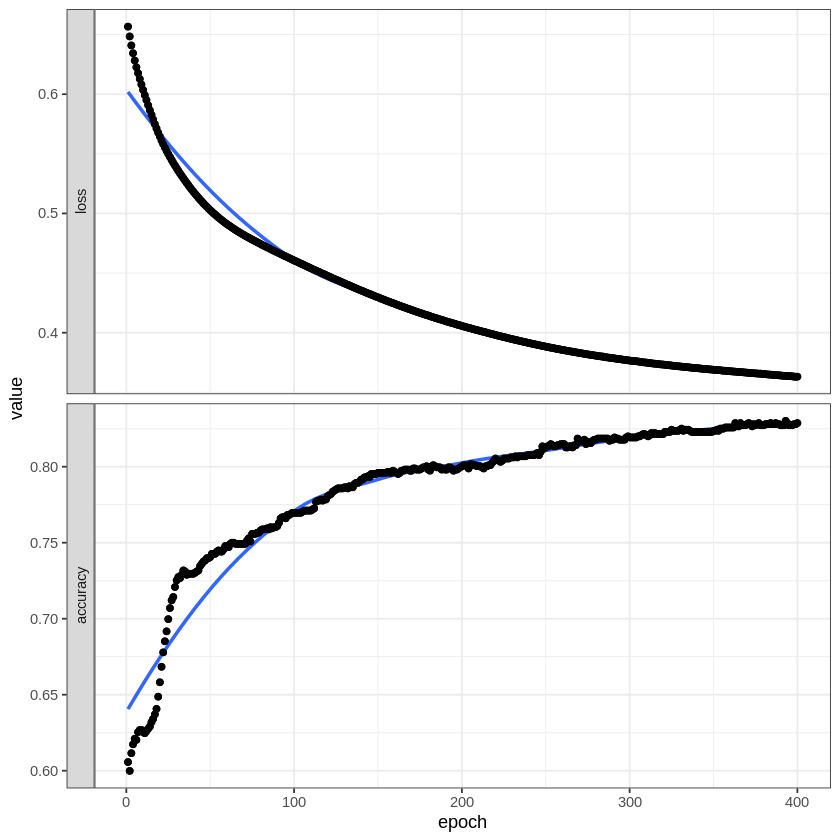

In [9]:
plot(history) + geom_point() + theme_bw()

### Plot Decision Boundary

Let's visualize which decision boundary was learned by the fcNN with the hidden layer As you can see the decision boundary is a now curved and not straight anymore. The model (with the hidden layer in the middle) separates the the two classes in the training data better and is able to learn non-linear decision boundaries.

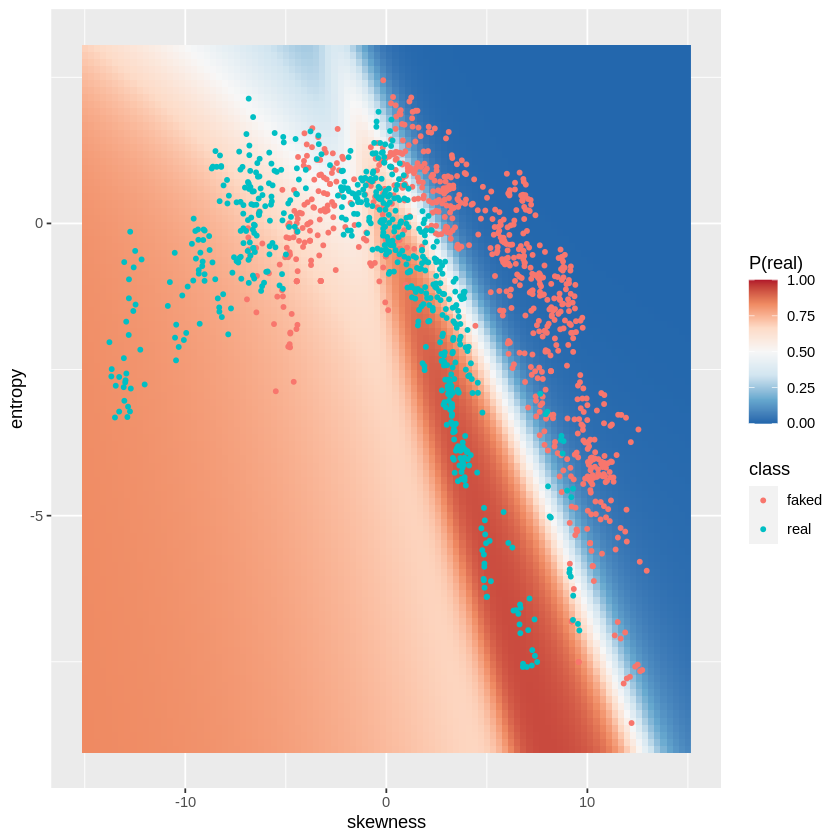

In [13]:
plotModel(X, Y, model, 'fcnn separation with hidden layer')

In [ ]:
table(d.plot$class, model$predict_classes(X))

       
          0   1
  faked 663  99
  real   72 538

#### Add more hidden layers and play around with the training epochs
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
Exercise: Add more hidden layers to the model and play around with the training epochs. What do you observe? Look at the learned decision boundary. How does the loss and the accuracy change?

A final note at the end. Here, we did not split our data into training and test or validation data. This is ok here, since we are mainly interested in the visualization of the decission boundary and not in developing a good prediction model. In real problems, however, you should always use a test-set or validation-set (not used in training) to evaluate the performance. You then can check the loss of the training and validation set after each weight update and for very flexible models you will observe, that the train loss goes to zero, but the validation loss first decreases, but then start in increase if your model starts to overfit the train data.